In [1]:
# Import Libraries
import numpy as np # vectors and matrices
import pandas as pd # tables and data manipulation
from datetime import datetime

import seaborn as sns # plots 
import matplotlib.pyplot as plt # more plots


from scipy.optimize import minimize # function minimization

import statsmodels.formula.api as smf    # statistics        
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product  # useful functions             
from tqdm import tqdm_notebook

# Set plots to a standard size
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9 

In [2]:
# PJM East Region: 2001-2018 (PJME)
 
series = pd.read_csv('PJME_hourly.csv'
                     ,index_col =[0], parse_dates = [0] # set the index column as dates
                     #,squeeze = True
                    )


PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

We'll use the PJM East Region dataset - which covers the eastern states of the PJM area. There isn't readily available data that identifies which regions are covered, so I'm going to assume (for this analysis) the following States (the coastal ones):

1. Delaware
2. Maryland
3. New Jersey
4. North Carolina
5. Pennsylvania
6. Virginia
7. District of Columbia

Data : The dataset contains hourly data from 2002 up to 2018 on the power consumption from several companies including PJM.

# Preprocessing

In [16]:
def series_clean(series):
    
    # Sorting 
    series.sort_index(inplace = True)
    
    # Dropping duplicates
    series = series[~series.index.duplicated()]
    
    # Setting the frequency to Hourly
    series = series.asfreq('H')
    
    # Renaming the PJME_MW column to energy consumption (ec)
    series.rename(columns = {'PJME_MW' : 'ec'}, inplace = True)
    
    # Filling the Missing values using the preceding values
    series.ec = series.ec.fillna(method = 'ffill')
    
    return series

In [17]:
# Creating a new dataframe using the simple cleaning function
df = data_clean(series)
df.head()

,ec
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [18]:
# Check for missing values
df.isna().sum()

ec    0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145392 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ec      145392 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [20]:
df.describe()

,ec
count,145392.000000
mean,32079.051915
std,6464.154020
min,14544.000000
25%,27571.000000
50%,31420.000000
75%,35647.250000
max,62009.000000


In [22]:
# Extracting new features  for yearly, monthly, weekly, etc. 
def new_features(df):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['month_name'] = df.index.month_name()
    df['week_of_year'] = df.index.weekofyear
    df['quarter'] = df.index.quarter
    df['day_of_week'] = df.index.dayofweek
    df['day_of_week_name'] = df.index.day_name()
    df['day_of_month'] = df.index.day
    df['day_of_year'] = df.index.dayofyear
    df['hour'] = df.index.hour
    
    return df


In [23]:
# Applying the function and checking if it works
df1 = new_features(df)
df1.head()

,ec,year,month,month_name,week_of_year,quarter,day_of_week,day_of_week_name,day_of_month,day_of_year,hour
Datetime,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,2002,1,January,1,1,1,Tuesday,1,1,1
2002-01-01 02:00:00,29265.0,2002,1,January,1,1,1,Tuesday,1,1,2
2002-01-01 03:00:00,28357.0,2002,1,January,1,1,1,Tuesday,1,1,3
2002-01-01 04:00:00,27899.0,2002,1,January,1,1,1,Tuesday,1,1,4
2002-01-01 05:00:00,28057.0,2002,1,January,1,1,1,Tuesday,1,1,5


In [25]:
# Grouping the EC with different frequency (yearly, monthly, weekly) to visualize 
df_year = df1.groupby('year')['ec'].sum()
df_month = df1.groupby('month_name', sort = False)['ec'].sum()
df_week_of_year = df1.groupby('week_of_year')['ec'].sum()
df_quarter = df1.groupby('quarter')['ec'].sum()
df_day_of_week = df1.groupby('day_of_week_name', sort = False)['ec'].sum()
df_day_of_month = df1.groupby('day_of_month')['ec'].sum()
df_day_of_year = df1.groupby('day_of_year')['ec'].sum()
df_hour = df1.groupby('hour')['ec'].sum()

Now that the DataFrames index has a date-time-index, we can explore the data and perform time series analysis. Will perform more pre-processing after some exploration if necessary. 

# Exploratory Data Analysis (EDA)

In [30]:
# interactive plots
import plotly.graph_objects as go                   
import plotly.express as px
from plotly.subplots import make_subplots

In [35]:
# Plotting the groupings created in the section above. 
# For yearly and quarterly
fig = make_subplots(rows=4, cols=1, vertical_spacing = 0.175,
                    subplot_titles=(['Year', 'Week of Year', 'Day of year', 'Quarter']))

fig.add_trace(go.Scatter(x=df_year.index, y = df_year), row=1, col=1)
fig.add_trace(go.Scatter(x=df_week_of_year.index, y=df_week_of_year), row=2, col=1)
fig.add_trace(go.Scatter(x=df_day_of_year.index, y=df_day_of_year), row=3, col=1)
fig.add_trace(go.Scatter(x=df_quarter.index, y=df_quarter), row=4, col=1)

fig.update_layout(title = 'Energy Consumption of PJME per', height = 800, showlegend = False)

fig.show()

In [34]:
# For Monthly, weekly, hourly
fig = make_subplots(rows=4, cols=1, vertical_spacing = 0.175,
                    subplot_titles=(['Month', 'Day of Week', 'Day of Month', 'Hour']))

fig.add_trace(go.Scatter(x=df_month.index, y=df_month), row=1, col=1)
fig.add_trace(go.Scatter(x=df_day_of_week.index, y=df_day_of_week), row=2, col=1)
fig.add_trace(go.Scatter(x=df_day_of_month.index, y=df_day_of_month), row=3, col=1)
fig.add_trace(go.Scatter(x=df_hour.index, y=df_hour), row=4, col=1)

fig.update_layout(title = 'Energy Consumption of PJME per', height = 800, showlegend = False)

fig.show()

Takeaways from the above visualizations: EC = energy consumption 
1. The yearly EC is constant up to 2015, a decreasing trend from 2015 to 2017. 
2. Monthly EC is high during the summer --peaking in July due to air conditioning? -- summers months should be closely monitored by the energy companies. 
3. Day of the week, we can see that the energy consumption drops during weekends, perhaps because certain companies do not function during weekends that use up significant energy?
4. The hourly EC shows increase starting 6 A.M. to 8 P.M. (20 in military time) then predictably is at lowest during the "sleep" times.
5. Week of year, day of year, and quarterly EC show the same pattern as the monhtly distribution (i.e. highest during summer). 

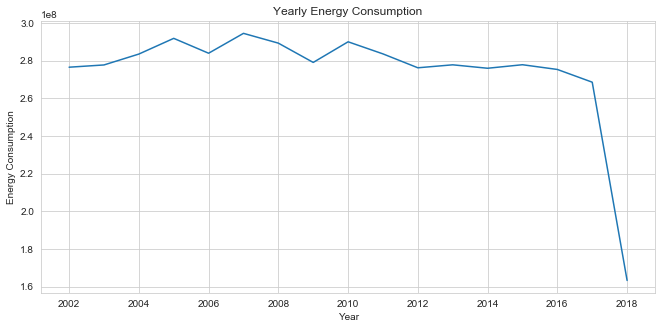

In [57]:
# Seaborn plots for presentation purposes for Yearly, Monthly, Daily, Hourly (total 4)
sns.set_style('whitegrid')

_ = plt.figure(figsize = [11,5])
_ = sns.lineplot(x=df_year.index, y = df_year, legend = False)
_ = plt.title('Yearly Energy Consumption')
_ = plt.ylabel('Energy Consumption')
_ = plt.xlabel('Year')

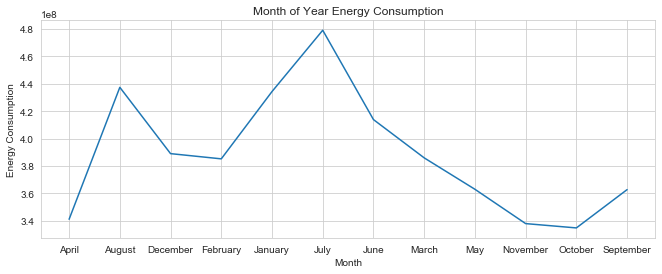

In [58]:
_ = plt.figure(figsize = [11,4])
_ = sns.lineplot(x=df_month.index, y=df_month, legend = False)
_ = plt.title('Month of Year Energy Consumption')
_ = plt.ylabel('Energy Consumption')
_ = plt.xlabel('Month')

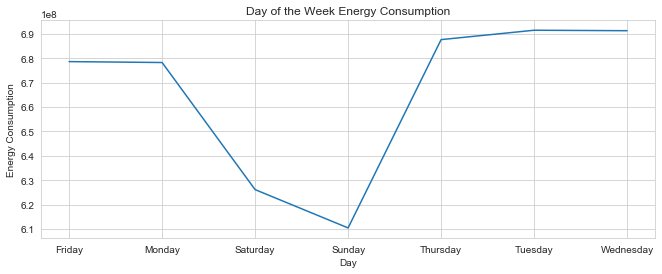

In [59]:
_ = plt.figure(figsize = [11,4])
_ = sns.lineplot(x=df_day_of_week.index, y=df_day_of_week, legend = False)
_ = plt.title('Day of the Week Energy Consumption')
_ = plt.ylabel('Energy Consumption')
_ = plt.xlabel('Day')

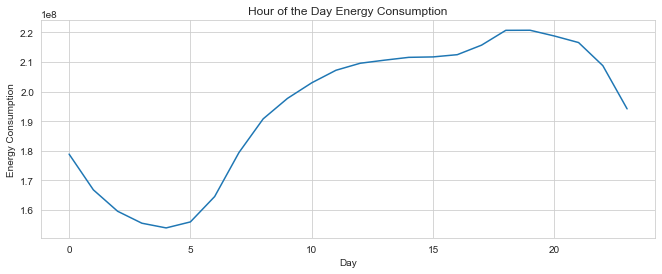

In [60]:
_ = plt.figure(figsize = [11,4])
_ = sns.lineplot(x=df_hour.index, y=df_hour, legend = False)
_ = plt.title('Hour of the Day Energy Consumption')
_ = plt.ylabel('Energy Consumption')
_ = plt.xlabel('Day')